In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing the necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
from tensorflow import keras
#

from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19

import warnings
# filter warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
submission = pd.read_csv('/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv')

In [4]:
submission.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [5]:
#Loading the image datasets
train_path = '../input/planets-dataset/planet/planet/train_classes.csv'
test_path = '../input/planets-dataset/planet/planet/sample_submission.csv'
train_images = '../input/planets-dataset/planet/planet/train-jpg/'
test_images = '../input/planets-dataset/planet/planet/test-jpg/'

In [6]:
df = pd.read_csv(train_path)

In [7]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
df.shape

(40479, 2)

In [9]:
df.nunique()

image_name    40479
tags            449
dtype: int64

In [10]:
df['tags'].value_counts()

clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: tags, Length: 449, dtype: int64

In [11]:
df_test = pd.read_csv(test_path)

In [12]:
df_test.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [13]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


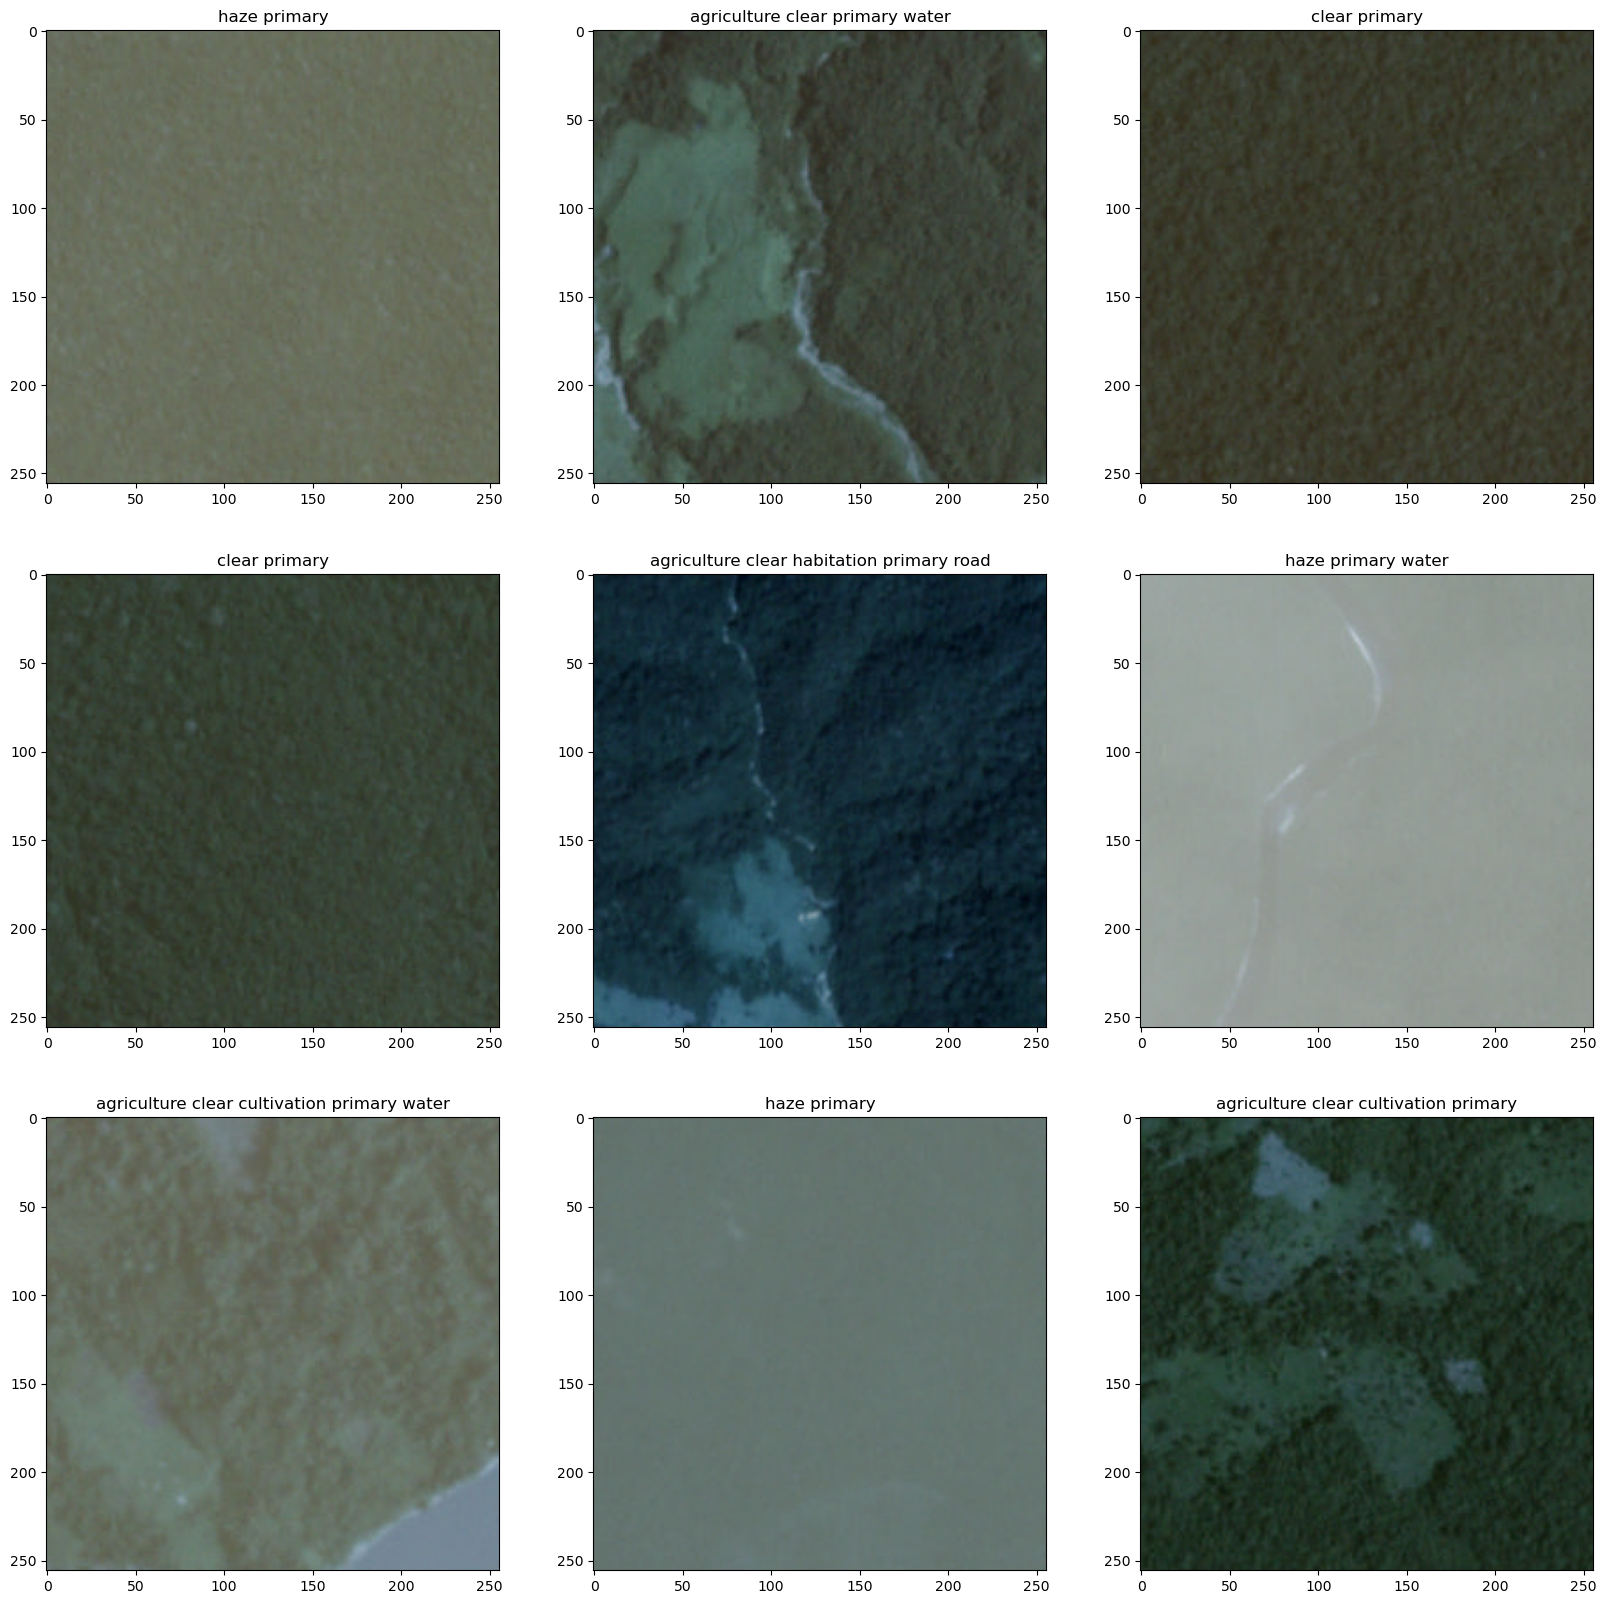

In [14]:
plt.figure(figsize=(20,20))

for i in range(9):
    
    plt.subplot(330 + 1 + i)
    
    filename = train_images + 'train_' + str(i) + '.jpg'
    
    image = cv2.imread(filename)
    
    plt.imshow(image)
    
    plt.title(df['tags'][i])

In [15]:
labels = set()
def splitting_tags(tags):
    '''
    Takes in tags column, splits the tags and store as a set
    '''
    [labels.add(tag) for tag in tags.split()]
    
# Create a copy of `train_df`
train_df1 = df.copy()
train_df1['tags'].apply(splitting_tags)
labels = list(labels)
print(labels)

['clear', 'artisinal_mine', 'water', 'cloudy', 'haze', 'habitation', 'cultivation', 'partly_cloudy', 'bare_ground', 'conventional_mine', 'blooming', 'primary', 'selective_logging', 'blow_down', 'slash_burn', 'agriculture', 'road']


In [16]:
train_df1.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [17]:
##One hot encoding is performed on the labels in train classes 
for tag in labels:
    train_df1[tag] = train_df1['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
## adding .jpg extension to the column image_name so as to have same name format as the image files
train_df1['image_name'] = train_df1['image_name'].apply(lambda x: '{}.jpg'.format(x))

In [18]:
train_df1.head()

,image_name,tags,clear,artisinal_mine,water,cloudy,haze,habitation,cultivation,partly_cloudy,bare_ground,conventional_mine,blooming,primary,selective_logging,blow_down,slash_burn,agriculture,road
0,train_0.jpg,haze primary,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,train_2.jpg,clear primary,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,train_3.jpg,clear primary,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1


In [19]:
# Define the columns
columns = list(train_df1.columns[2:])
columns

['clear',
 'artisinal_mine',
 'water',
 'cloudy',
 'haze',
 'habitation',
 'cultivation',
 'partly_cloudy',
 'bare_ground',
 'conventional_mine',
 'blooming',
 'primary',
 'selective_logging',
 'blow_down',
 'slash_burn',
 'agriculture',
 'road']

In [20]:
train_datagen = ImageDataGenerator( rescale = 1./255, 
                                  horizontal_flip = True,  
                                  width_shift_range = 0.1, 
                                height_shift_range = 0.1, 
                             rotation_range = 10,
                                  validation_split=0.2)

# Generating train data generator 
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df1,
                                                    directory =train_images, 
                                                    x_col='image_name', 
                                                    y_col=columns, 
                                                    subset='training', 
                                                    batch_size=32,
                                                    shuffle=True, 
                                                    class_mode='raw', 
                                                    target_size=(128,128))

val_datagen = ImageDataGenerator( rescale = 1./255, validation_split=0.2)

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = val_datagen.flow_from_dataframe(dataframe=train_df1,
                                                  directory =train_images, 
                                                  x_col='image_name', 
                                                  y_col=columns, 
                                                  subset='validation', 
                                                  batch_size=32,
                                                  shuffle=True, 
                                                  class_mode='raw', 
                                                  target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [32]:
base_model = VGG19(include_top=False,
                       weights='imagenet',
                       input_shape=(128,128,3))

In [22]:
#for i, layer in enumerate(base_model.layers):
 #   layer.trainable =False

In [33]:
img_size = 128 
num_classes = 17


x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = BatchNormalization()(x)
predictions = tf.keras.layers.Dense(num_classes, activation = 'sigmoid')(x)

model = Model(inputs = base_model.input, outputs = predictions)   #check if input size can be turned off
#set_non_trainable_layers(base_model, 0, 21)

for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)
#model.summary()

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 flatten_4 True
23 batch_normalization_4 True
24 dense_4 True


In [34]:
opt = Adam(lr=1e-4)

model.compile(loss='binary_crossentropy',
                  # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer=opt,
                  metrics=['accuracy'])

# define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [35]:
# Fit the model 
history = model.fit(x = train_generator,
                    validation_data = val_generator,
                    epochs = 20,
                   callbacks = earlystop)

Epoch 1/20
1012/1012 [==============================] - 280s 270ms/step - loss: 0.2297 - accuracy: 0.0344 - val_loss: 0.3303 - val_accuracy: 0.0124
Epoch 2/20
1012/1012 [==============================] - 266s 263ms/step - loss: 0.1994 - accuracy: 0.0564 - val_loss: 5.4661 - val_accuracy: 0.1663
Epoch 3/20
1012/1012 [==============================] - 291s 287ms/step - loss: 0.1962 - accuracy: 0.0682 - val_loss: 0.3607 - val_accuracy: 0.2380
Epoch 4/20
1012/1012 [==============================] - 282s 279ms/step - loss: 0.1904 - accuracy: 0.0876 - val_loss: 1002.7188 - val_accuracy: 0.1145
Epoch 5/20
1012/1012 [==============================] - 267s 263ms/step - loss: 0.1812 - accuracy: 0.1196 - val_loss: 0.1819 - val_accuracy: 0.1095
Epoch 5: early stopping


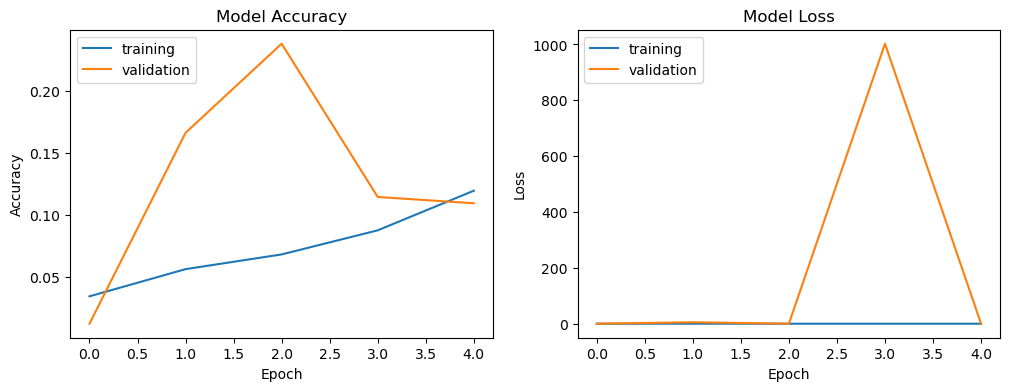

In [36]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [37]:
##adding .jpg extension to image name in the sample submission file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission1 = sample_submission.copy()
sample_submission1['image_name'] = sample_submission1['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [38]:
sample_submission1.shape

(61191, 2)

In [39]:
# Divide the sample submission file into two splits,
# first test1_df contains the first 40669 images 
test_df1 = sample_submission1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_df1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [40]:
#initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

Found 40669 validated image filenames.


In [41]:
#first, we reset the test generator to avoid shuffling of index 
test_gen.reset()
pred = model.predict(test_gen, verbose=1)

1271/1271 [==============================] - 298s 234ms/step


In [42]:
pred

array([[9.43052113e-01, 3.49262409e-04, 5.82430996e-02, ...,
        1.87431392e-03, 1.16441555e-01, 4.30984087e-02],
       [9.80043173e-01, 2.46620093e-05, 1.90809835e-02, ...,
        8.71816592e-04, 4.13472997e-03, 7.08788913e-03],
       [7.25746453e-01, 1.93904343e-04, 3.99336033e-02, ...,
        3.34009109e-03, 3.77910107e-01, 1.64435022e-02],
       ...,
       [9.64645207e-01, 7.40647141e-04, 8.84206221e-02, ...,
        1.17388705e-03, 5.59516907e-01, 2.63580561e-01],
       [3.55484158e-01, 3.13270983e-04, 4.86555099e-02, ...,
        2.13077897e-03, 1.03375770e-01, 1.64870545e-02],
       [9.80739474e-01, 2.27950404e-05, 1.74226947e-02, ...,
        8.27326730e-04, 3.62976291e-03, 6.52636867e-03]], dtype=float32)

In [43]:
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.943052,0.000349,0.058243,0.000892,0.006178,0.010251,0.025941,0.042838,0.002404,7.316688e-05,0.003783,0.994484,0.002494,0.000058,0.001874,0.116442,0.043098
1,0.980043,0.000025,0.019081,0.003600,0.000821,0.001169,0.001619,0.014171,0.000629,7.164410e-03,0.014587,0.961892,0.030965,0.000021,0.000872,0.004135,0.007088
2,0.725746,0.000194,0.039934,0.000232,0.049074,0.005419,0.131775,0.053091,0.000302,1.340844e-06,0.000860,0.999760,0.000096,0.000022,0.003340,0.377910,0.016444
3,0.959624,0.000079,0.054403,0.001217,0.000700,0.003551,0.007588,0.030630,0.001778,5.460116e-03,0.008950,0.987084,0.022442,0.000082,0.001456,0.021635,0.023316
4,0.042026,0.002194,0.111149,0.170587,0.126028,0.002096,0.058970,0.085775,0.006031,4.112579e-09,0.000023,0.826040,0.000021,0.000023,0.000516,0.121134,0.012015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40664,0.942396,0.000111,0.029054,0.001878,0.002189,0.002769,0.009245,0.031985,0.000905,1.439753e-04,0.006073,0.989235,0.006184,0.000031,0.001865,0.020877,0.015752
40665,0.631761,0.000176,0.367511,0.001266,0.000167,0.016745,0.048276,0.367319,0.006693,6.606909e-03,0.001675,0.990947,0.026896,0.000345,0.003620,0.126158,0.128149
40666,0.964645,0.000741,0.088421,0.000071,0.006431,0.075333,0.064117,0.031826,0.019365,8.019920e-05,0.001849,0.998206,0.000723,0.000291,0.001174,0.559517,0.263581
40667,0.355484,0.000313,0.048656,0.003350,0.115783,0.002727,0.114689,0.089423,0.000670,3.533473e-08,0.000458,0.995955,0.000158,0.000012,0.002131,0.103376,0.016487


In [44]:
# Get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# Convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,clear primary
3,test_3.jpg,clear primary
4,test_4.jpg,primary


In [45]:
#second batch of the test dataset
additional_df = sample_submission1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [46]:
#creating a generator for the second batch of test image files
test_gen1 = test_datagen.flow_from_dataframe(dataframe=additional_df, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

Found 20522 validated image filenames.


In [47]:
#we reset the generator to avoid shuffling, then make prediction on the generator
test_gen1.reset()
pred1 = model.predict(test_gen1, verbose = 1)

642/642 [==============================] - 138s 214ms/step


In [48]:
#this is to get the filenames in the generator using the attribute .filenames
file_names1 = test_gen1.filenames

#convert the predicted values to a dataframe
#join two labels together if the prob(occurrance of the label) > 0.5
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(labels)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result2.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,clear primary
2,file_10.jpg,haze primary
3,file_100.jpg,clear primary
4,file_1000.jpg,clear primary


In [49]:
# Final result of the predicted tags for the test images,
# we need to concat the first and second results in 
#that order to avoid shuffling the index
final_df = pd.concat([result1, result2])

final_df = final_df.reset_index().drop('index', axis =1)

print(final_df.shape)
final_df.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,clear primary
3,test_3.jpg,clear primary
4,test_4.jpg,primary


In [50]:
# Remove the .jpg extension from the image_name of the last_result 
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,clear primary
3,test_3,clear primary
4,test_4,primary


In [51]:
# Finally, we save the result to a csv file using the .to_csv() 
# method and setting the index to false.
final_df.to_csv('submission2.csv', index = False)

In [52]:
sub = pd.read_csv('/kaggle/working/submission2.csv')

In [53]:
sub.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,clear primary
3,test_3,clear primary
4,test_4,primary
